In [92]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from statsmodels.sandbox.regression.gmm import IV2SLS
from linearmodels.iv import IV2SLS
from scipy.stats import chi2

In [4]:
df = pd.read_excel('_46d7b6e393ed4cd5a42ba1ec49adede2_TestExer4_Wage-round1.xlsx')
df.head()

,logw,educ,age,exper,smsa,south,nearc,daded,momed
0,6.306275,7,29,16,1,0,0,9.94,10.25
1,6.175867,12,27,9,1,0,0,8.00,8.00
2,6.580639,12,34,16,1,0,0,14.00,12.00
3,5.521461,11,27,10,1,0,1,11.00,12.00
4,6.591674,12,34,16,1,0,1,8.00,7.00


In [6]:
df.shape

(3010, 9)

## Analise gráfica

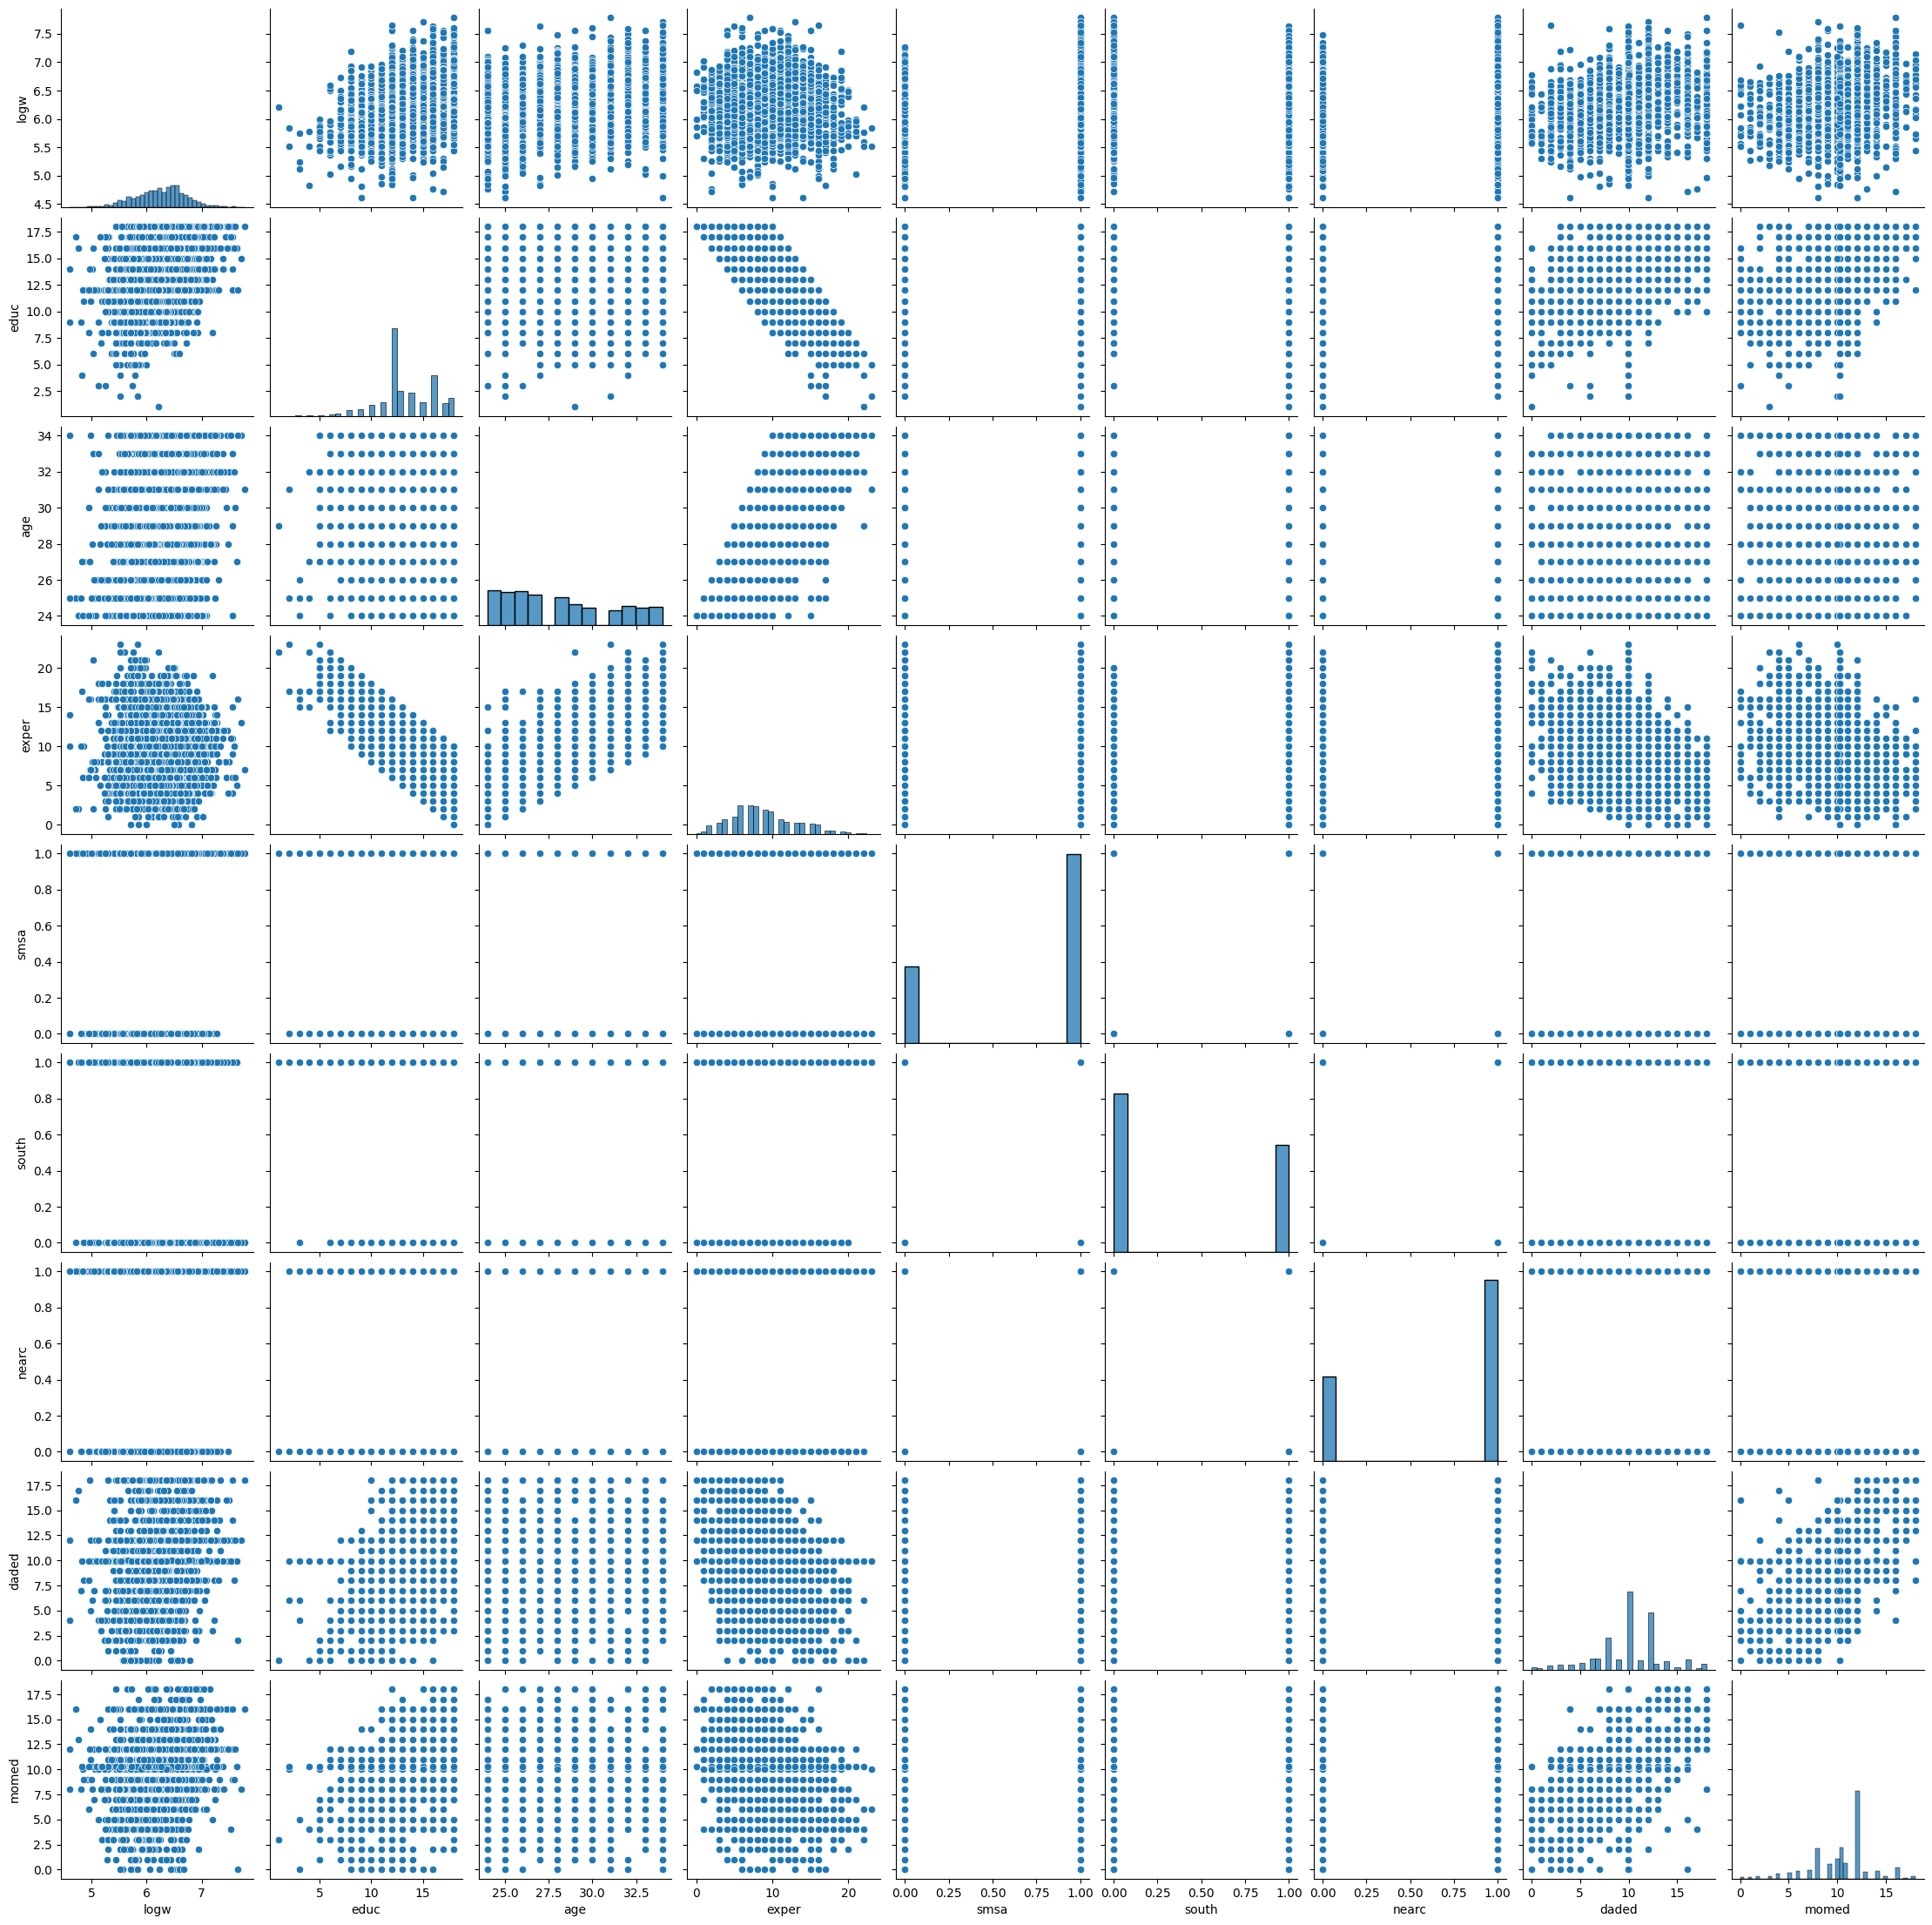

In [9]:
sns.pairplot(data=df);

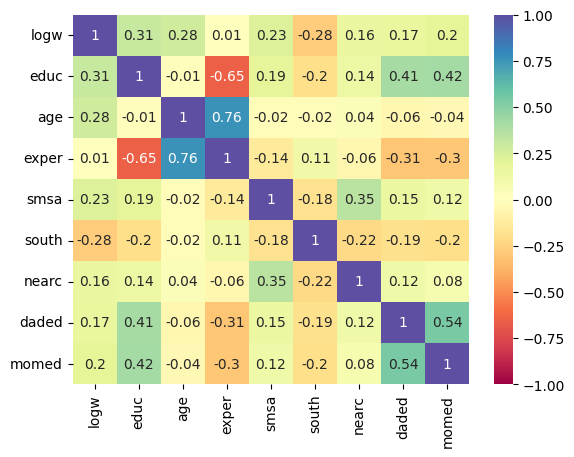

In [11]:
sns.heatmap(data=round(df.corr(), 2), annot=True, vmax=1, vmin=-1, cmap='Spectral');

## (a) 
* Use OLS to estimate the parameters of the model 
logw = β1 + β2educ + β3exper + β4exper2 + β5smsa + β6south + ε 
Give an interpretation to the estimated β2 coefficient.

In [12]:
df['exper2'] = df['exper'] ** 2

In [14]:
X = df[['educ', 'exper', 'exper2', 'smsa', 'south']]
y = df['logw']

In [15]:
X = sm.add_constant(X)

In [16]:
modelo = sm.OLS(y, X).fit()

In [18]:
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                   logw   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     214.6
Date:                Tue, 22 Apr 2025   Prob (F-statistic):          3.70e-196
Time:                        23:07:23   Log-Likelihood:                -1365.6
No. Observations:                3010   AIC:                             2743.
Df Residuals:                    3004   BIC:                             2779.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6110      0.068     67.914      0.0

### Um ano adicional de escolaridade está associado, em média, a um aumento de 8,16% no salário, uma vez que a variável dependente é o logaritmo do salário. Esse efeito é interpretado como um aumento percentual aproximado, assumindo pequenas variações.

## (b) 
* OLS may be inconsistent in this case as educ and exper may be endogenous. Give a reason why this may be 
the case. Also indicate whether the estimate in part (a) is still useful.

### O OLS pode ser inconsistente quando uma ou mais variáveis explicativas são endógenas, ou seja, correlacionadas com o termo de erro (ε). Isso viola uma das principais suposições do OLS:

* E[ε | X] = 0, ou seja, o erro deve ser incorrelato com os regressores.
  

In [36]:
exoge = df[['exper', 'exper2', 'smsa', 'south']]
exog = sm.add_constant(exoge)

In [37]:
endog = df['educ']

In [38]:
instrument = df[['nearc']]

In [39]:
instrument = sm.add_constant(pd.concat([instrument, exog.iloc[:, 1:]], axis=1))

In [51]:
# Criar a variável experiência ao quadrado
df['exper2'] = df['exper'] ** 2

# Fórmula como string — ESSENCIAL
formula = 'logw ~ 1 + exper + exper2 + smsa + south + [educ ~ nearc]'

# Estimar o modelo IV
model = IV2SLS.from_formula(formula, data=df)
results = model.fit()

# Mostrar o resumo dos resultados
print(results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   logw   R-squared:                      0.2051
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2038
No. Observations:                3010   F-statistic:                    534.87
Date:                Tue, Apr 22 2025   P-value (F-stat)                0.0000
Time:                        23:53:50   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.7034     0.8079     4.5841     0.0000      2.1200      5.2869
exper          0.1068     0.0216     4.9403     0.00

In [56]:
print("\n--- Interpretação dos Resultados ---")

print("\nCoeficiente de 'educ' via OLS:")
print(f"{modelo.params['educ']:.4f} → Cada ano adicional de escolaridade está associado a um aumento de {modelo.params['educ']*100:.2f}% no salário, assumindo exogeneidade.")

print("\nCoeficiente de 'educ' via IV:")
print(f"{results.params['educ']:.4f} → Estimativa robusta ao viés de habilidade não observada. Representa o efeito causal local (LATE).")

print("\nOBS: Se o coeficiente IV for maior que o do OLS, pode indicar que o OLS subestima o retorno da escolaridade devido à endogeneidade (ex: capacidade não observada correlacionada com educação e salário).")


--- Interpretação dos Resultados ---

Coeficiente de 'educ' via OLS:
0.0816 → Cada ano adicional de escolaridade está associado a um aumento de 8.16% no salário, assumindo exogeneidade.

Coeficiente de 'educ' via IV:
0.1354 → Estimativa robusta ao viés de habilidade não observada. Representa o efeito causal local (LATE).

OBS: Se o coeficiente IV for maior que o do OLS, pode indicar que o OLS subestima o retorno da escolaridade devido à endogeneidade (ex: capacidade não observada correlacionada com educação e salário).


## (c) 
* Give a motivation why age and age2 
can be used as instruments for exper and exper2
.

### Respostas:
* Um instrumento válido para uma variável endógena (como exper) precisa satisfazer duas condições principais:
* Relevância: o instrumento deve estar correlacionado com a variável endógena (ex: idade deve estar correlacionada com exper);
* Exogeneidade: o instrumento não deve estar correlacionado com o erro do modelo (ex: idade não deve afetar diretamente logw, exceto por meio de exper).
### Por que idade e idade² são bons candidatos a instrumentos para exper e exper² ? 
* A experiência de trabalho (exper) geralmente é derivada da idade menos os anos de educação e da idade de início no mercado de trabalho.
* Logo, pessoas mais velhas tendem a ter mais experiência, ainda que com diferenças individuais.
* Portanto, idade e idade² estão fortemente correlacionadas com exper e exper² → isso garante relevância.
* A suposição é que a idade em si não afeta diretamente o salário depois de controlarmos por experiência e escolaridade.
* Ou seja: qualquer efeito da idade no salário é mediado por experiência, não por um efeito direto da idade.
* Sob essa suposição, idade é exógena ao erro do modelo → o que garante exogeneidade.

## (d) 
* Run the first-stage regression for educ for the two-stage least squares estimation of the parameters in the 
model above when age, age
, nearc, dadeduc, and momeduc are used as additional instruments. What do y u
conclude about the suitability of these instruments for schooling?

In [58]:
df["age2"] = df["age"] ** 2

In [61]:
y = df["educ"]
X = df[["age", "age2", "nearc", "daded", "momed"]]
X = sm.add_constant(X)

In [62]:
first_stage = sm.OLS(y, X).fit()

In [63]:
print("\n--- Primeira Fase: Regressão de 'educ' nos instrumentos ---")
print(first_stage.summary())


--- Primeira Fase: Regressão de 'educ' nos instrumentos ---
                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     182.5
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          4.51e-170
Time:                        00:21:40   Log-Likelihood:                -6835.1
No. Observations:                3010   AIC:                         1.368e+04
Df Residuals:                    3004   BIC:                         1.372e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

## (e) 
* Estimate the parameters of the model for log wage using two-stage least squares where you correct for the 
endogeneity of education and experience. Compare your result to the estimate in part (a).

In [64]:
df.columns

Index(['logw', 'educ', 'age', 'exper', 'smsa', 'south', 'nearc', 'daded',
       'momed', 'exper2', 'age2'],
      dtype='object')

In [80]:
# Variáveis endógenas
endog = df[["educ", "exper" ,"exper2"]]

# Variáveis exógenas
exog = df[["smsa", "south"]]

# Instrumentos
instr_vars = df[["age", "age2", "nearc", "daded", "momed"]]
instruments = pd.concat([instr_vars, df[["smsa", "south"]]], axis=1)

# Variável dependente
y = df["logw"]


In [81]:
iv_model = IV2SLS(
    dependent=y,
    exog=exog,                     
    endog=endog,                    
    instruments=instr_vars          
).fit()

In [82]:
print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   logw   R-squared:                      0.9738
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9737
No. Observations:                3010   F-statistic:                 1.341e+05
Date:                Thu, Apr 24 2025   P-value (F-stat)                0.0000
Time:                        23:17:11   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
smsa           0.0455     0.0470     0.9679     0.3331     -0.0466      0.1376
south         -0.0293     0.0388    -0.7560     0.44

In [79]:
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                   logw   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     214.6
Date:                Thu, 24 Apr 2025   Prob (F-statistic):          3.70e-196
Time:                        23:15:32   Log-Likelihood:                -1365.6
No. Observations:                3010   AIC:                             2743.
Df Residuals:                    3004   BIC:                             2779.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6110      0.068     67.914      0.0

### Resposta 
* Analisnado o 2SLS educ = 0.1628, podemos perceber que o coeficiente possui maior do que o primeiro modelo em (a), é um indício de que a escolaridade estava subestimada no OLS devido à endogeneidade.

## (f) 
* Perform the Sargan test for validity of the instruments. What is your conclusion?

In [85]:
iv_model.sargan

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 2.1730
P-value: 0.3374
Distributed: chi2(2)
WaldTestStatistic, id: 0x24216689e90

## 🧠 Interpretação:
* p > 0.05 → instrumentos parecem válidos ✅